In [1]:
import numpy as np
import cvxpy as cvx
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline 

In [2]:
data = pd.read_csv('MIPC 2018 Total Liabilities.csv')
data.columns = data.iloc[0]
data.drop(data.index[0], inplace=True)
data.reset_index(drop=True,inplace=True)
active = data['Active']
active = pd.to_numeric(active)
retirees = data['Retirees']
retirees = pd.to_numeric(retirees)
total = data['Total']
total = pd.to_numeric(total)

In [3]:
N = 50
N_bar=6
e1 = 0.05
beta = 0.5

tau = 3.0
D = np.array([[0,1,0,0,0],[0,0,1,0,0],[0,0,0,1,0],[0,0,0,0,0],[0,0,0,0,1]])
d = np.array([1,0,0,0,0])
cash = np.array([1,0,0,0,0])
discount_rate = 0.07
asset_initial_value= 1450000000

z = np.zeros((N,3))
z[0,0] = 4.5794
z[0,1] = -0.3443
z[0,2] = -0.2767
m = np.array([6.1694,-2.4183,0.4244])
mu = np.array([0.0783])
q0 = 1248.29

V = np.array([[2.1775,-4.5778,19.3399,-0.1201],
             [-4.5778,15.6181,-43.6039,0.2679],
             [19.3399,-43.6039,179.7153,-1.0094],
             [-0.1201,0.2679,-1.0094,0.0078]])
A = np.linalg.cholesky(V)
rho = (V*V.T)[:3,:3]

In [4]:
def spot_rate(t,j,z,tau=3):
    s = z[t,0] + z[t,1]*((1-np.exp(-j/tau))/(j/tau)) + z[t,2]*((1-np.exp(-j/tau))/(j/tau)-np.exp(-j/tau))
    return s

In [5]:
def discounted_liabilities(liabilities,discount_rate,N):
    cumm_dis_lia = np.zeros(N)
    for i in range(len(cumm_dis_lia)):
        for j in range(i,len(liabilities)):
            cumm_dis_lia[i] = cumm_dis_lia[i] + liabilities[j]/np.power(1+discount_rate,j-i)
    return cumm_dis_lia/(1+discount_rate)

In [6]:
def grad_z1(t,j,z,tau=3):
    spot_rate = z[t,0] + z[t,1]*((1-np.exp(-j/tau))/(j/tau)) + z[t,2]*((1-np.exp(-j/tau))/(j/tau)-np.exp(-j/tau))
    grad_value = -j*np.power(1+spot_rate,-j-1)
    return grad_value

In [7]:
def grad_z2(t,j,z,tau=3):
    spot_rate = z[t,0] + z[t,1]*((1-np.exp(-j/tau))/(j/tau)) + z[t,2]*((1-np.exp(-j/tau))/(j/tau)-np.exp(-j/tau))
    grad_value = -j*np.power(1+spot_rate,-j-1)*((1-np.exp(-j/tau))/(j/tau))
    return grad_value

In [8]:
def grad_z3(t,j,z,tau=3):
    spot_rate = z[t,0] + z[t,1]*((1-np.exp(-j/tau))/(j/tau)) + z[t,2]*((1-np.exp(-j/tau))/(j/tau)-np.exp(-j/tau))
    grad_value = -j*np.power(1+spot_rate,-j-1)*((1-np.exp(-j/tau))/(j/tau)-np.exp(-j/tau))
    return grad_value

In [9]:
def grad_z1z1(t,j,z,tau=3):
    spot_rate = z[t,0] + z[t,1]*((1-np.exp(-j/tau))/(j/tau)) + z[t,2]*((1-np.exp(-j/tau))/(j/tau)-np.exp(-j/tau))
    grad_value = -j*(-j-1)*np.power(1+spot_rate,-j-2)
    return grad_value

In [10]:
def grad_z1z2(t,j,z,tau=3):
    spot_rate = z[t,0] + z[t,1]*((1-np.exp(-j/tau))/(j/tau)) + z[t,2]*((1-np.exp(-j/tau))/(j/tau)-np.exp(-j/tau))
    grad_value = -j*(-j-1)*((1-np.exp(-j/tau))/(j/tau))*np.power(1+spot_rate,-j-2)
    return grad_value

In [11]:
def grad_z1z3(t,j,z,tau=3):
    spot_rate = z[t,0] + z[t,1]*((1-np.exp(-j/tau))/(j/tau)) + z[t,2]*((1-np.exp(-j/tau))/(j/tau)-np.exp(-j/tau))
    grad_value = -j*(-j-1)*((1-np.exp(-j/tau))/(j/tau)-np.exp(-j/tau))*np.power(1+spot_rate,-j-2)
    return grad_value

In [12]:
def grad_z2z2(t,j,z,tau=3):
    spot_rate = z[t,0] + z[t,1]*((1-np.exp(-j/tau))/(j/tau)) + z[t,2]*((1-np.exp(-j/tau))/(j/tau)-np.exp(-j/tau))
    grad_value = -j*(-j-1)*np.power(1+spot_rate,-j-2)*np.power(((1-np.exp(-j/tau))/(j/tau)),2)
    return grad_value

In [13]:
def grad_z2z3(t,j,z,tau=3):
    spot_rate = z[t,0] + z[t,1]*((1-np.exp(-j/tau))/(j/tau)) + z[t,2]*((1-np.exp(-j/tau))/(j/tau)-np.exp(-j/tau))
    grad_value = -j*(-j-1)*np.power(1+spot_rate,-j-2)*((1-np.exp(-j/tau))/(j/tau))*((1-np.exp(-j/tau))/(j/tau)-np.exp(-j/tau))
    return grad_value

In [14]:
def grad_z3z3(t,j,z,tau=3):
    spot_rate = z[t,0] + z[t,1]*((1-np.exp(-j/tau))/(j/tau)) + z[t,2]*((1-np.exp(-j/tau))/(j/tau)-np.exp(-j/tau))
    grad_value = -j*(-j-1)*np.power(1+spot_rate,-j-2)*np.power(((1-np.exp(-j/tau))/(j/tau)-np.exp(-j/tau)),2)
    return grad_value

In [15]:
def delta_p_j(j,m,z,mu,rho,tau=3):
    grad_z = np.array([grad_z1(0,j,z,tau),grad_z2(0,j,z,tau),grad_z3(0,j,z,tau)])
    doublegrad_z = np.array([[grad_z1z1(0,j,z,tau),grad_z1z2(0,j,z,tau),grad_z1z3(0,j,z,tau)],
                            [grad_z1z2(0,j,z,tau),grad_z2z2(0,j,z,tau),grad_z2z3(0,j,z,tau)],
                            [grad_z1z3(0,j,z,tau),grad_z2z3(0,j,z,tau),grad_z3z3(0,j,z,tau)]])
    first = np.sum((m-z[0,:])*grad_z)
    second = np.sum(0.5*rho*doublegrad_z)
    return first+second

In [16]:
delta_p = np.zeros(5)
print(len(delta_p))
for j in range(len(delta_p)):
    if j==len(delta_p)-1:
        delta_p[j]=q0*mu
    else:
        delta_p[j] = delta_p_j(j+1,m,z,mu,tau)

grad_p = np.zeros((5,4))
for index,x in np.ndenumerate(grad_p):
    if index[0]==4 or index[1]==3:
        grad_p[index[0],index[1]] = 0
    elif index[1]==0 :
        grad_p[index[0],index[1]]= grad_z1(0,index[0]+1,z,tau)
    elif index[1]==1 :
        grad_p[index[0],index[1]]= grad_z2(0,index[0]+1,z,tau)
    else :
        grad_p[index[0],index[1]]= grad_z3(0,index[0]+1,z,tau)
grad_p[4,3]=q0

5


/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


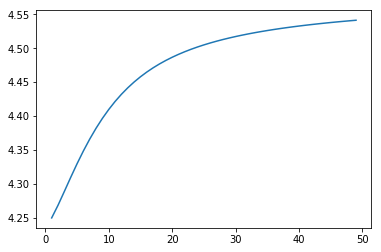

In [17]:
spot = np.zeros(50)
for j in range(50):
    spot[j] = spot_rate(0,j,z,3)

plt.plot(spot)

In [18]:
cumm_dis_lia = discounted_liabilities(total,discount_rate,N)


In [19]:
#cvx variable declaration
theta = cvx.Variable((N_bar+1,5))
w = cvx.Variable(N_bar)

In [20]:
p0 = np.array([1/spot_rate(0,1,z,tau=3),
               1/spot_rate(0,2,z,tau=3),
               1/spot_rate(0,3,z,tau=3),
               1/spot_rate(0,4,z,tau=3),
               1248.29])

In [21]:
norm.ppf(1-e1)

1.6448536269514722

In [22]:
# constraints
constraints = [];

# (4) constraint
constraints+= [p0*theta[0,:] == asset_initial_value]

# (18) constraint
for t in range(1,N_bar):
    constraints+= [cvx.norm((D*theta[t-1,:]-theta[t,:])*np.matmul(grad_p,V))*np.sqrt(t)*norm.ppf(1-e1) <= (p0+delta_p*t)*(D*theta[t-1,:]-theta[t,:])+d*theta[t-1,:]+w[t-1]-total[t-1]]


# (19) constraint
t= N_bar
constraints+= [cvx.norm((D*theta[t-1,:]-theta[t,:])*np.matmul(grad_p,V))*np.sqrt(t)*norm.ppf(1-e1) <=(p0+delta_p*t)*(D*theta[t-1,:])+d*theta[t-1,:]+w[t-1]-total[t-1]-beta*cumm_dis_lia[t]]


#
constraints+=[w>=0]
constraints+=[theta>=0]

constraints

[Zero(Expression(AFFINE, UNKNOWN, ())),
 NonPos(Expression(CONVEX, UNKNOWN, ())),
 NonPos(Expression(CONVEX, UNKNOWN, ())),
 NonPos(Expression(CONVEX, UNKNOWN, ())),
 NonPos(Expression(CONVEX, UNKNOWN, ())),
 NonPos(Expression(CONVEX, UNKNOWN, ())),
 NonPos(Expression(CONVEX, UNKNOWN, ())),
 NonPos(Expression(AFFINE, UNKNOWN, (6,))),
 NonPos(Expression(AFFINE, UNKNOWN, (7, 5)))]

In [29]:
#objective
objective = cvx.Minimize(sum(w))

p = cvx.Problem(objective, constraints)
p.setParam("FeasibilityTol",1e-2)
result = p.solve(solver = cvx.GUROBI,verbose = True, FeasibilityTol = 1e-2)

AttributeError: 'Problem' object has no attribute 'setParam'

AttributeError: module 'cvxpy' has no attribute 'cvx_solver_settings'

In [ ]:
result

In [ ]:
print(w.value)

In [ ]:
print(sum(p0*theta.value[0,:]))
print(p0*theta.value[0,:])

In [ ]:
t=6
#print(np.matmul(np.matmul(D,theta.value[t-1,:])-theta.value[t,:],np.matmul(grad_p,V)))
print(np.linalg.norm(np.matmul(np.matmul(D,theta.value[t-1,:])-theta.value[t,:],np.matmul(grad_p,V)))*np.sqrt(t)*norm.ppf(1-e1))

In [ ]:
print(np.matmul((p0+delta_p*t),(np.matmul(D,theta.value[t-1,:])-theta.value[t,:]))+np.matmul(d,theta.value[t-1,:])-total[t-1]+w.value[t-1])

In [ ]:
print(np.matmul((p0+delta_p*t),(np.matmul(D,theta.value[t-1,:])))+np.matmul(d,theta.value[t-1,:])-total[t-1]-beta*cumm_dis_lia[t]+w.value[t-1])

In [ ]:
beta

In [ ]:
theta.value